# Telco Churn

In [1]:
# .py file imports 
from env import password, host, user
import acquire
import prepare

# Data science libraries
import pandas as pd
import numpy as np



# For exploration
from math import sqrt
from scipy import stats

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# For scaling and Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

# For modeling
import model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



# Acquire

In [2]:
# This function checks to see if the csv file already exists. 
# If it doesn't, it will create a new csv file by connecting to sql database.

acquire.check_for_csv_file("telco_churn_data.csv")

In [3]:
# This function reads the csv data
telco = acquire.read_telco_data()

In [4]:
# What is the overall shape of the data?
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
internet_service_type_id    7043 non-null int64
payment_type_id             7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [5]:
# What do the first 5 rows look like?
telco.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
1,1,4,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,Credit card (automatic),DSL
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,Electronic check,DSL
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,Electronic check,DSL
4,1,3,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,Bank transfer (automatic),DSL


In [6]:
# What does monthly charges looks like?
telco.monthly_charges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

In [7]:
# What does tenure looks like?
telco.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

## Why are customers churning?

Our main hypothesis at the moment is that customers are churning because they don't see the value in our services, and as such, they are becoming very price driven. Given an abudance of competition in the market, customers have the freedom to "shop" around for the best price, even if it means constantly changing providers. As a result, the majority of customers will likely be looking for short-term contracts, or low commitment contracts, which offer lower barriers to switching. 

While the majority of customers behavior will likely follow the hypothesis above.
We believe that reasons for customer churn are:
    
1. **price sensitivity**
1. customer satisfaction
1. product satisfaction
1. relocation


Although hopefully less likely, there also exist a possibility that a customer will churn due to less-than-great service. This can mean drop in services (or slower than expected services) for a period of time, or a bad experience with customer service, such as long wait times before speaking to a representative. There will also be customers that fall within this category, and any of these negative experiences will be a strong motivator to churn. A lack of service that a competitor offers is also not available. If there are customers churning because a competitor has a unique offering, that could be a strong motivator for customers to churn as well. Unfortunately, given that data, we cannot tell if there are any customers that churned for this reasons.

Given the data provided, we will focus on answering the question to the best of our abilities, removing the assumption that customers can leave for any reason other than the one the data can prove. While we will be mindful that there will be other reasons, becasue we can't prove or disprove them, we will not consider them at this time. 

* $H_0$: Customers are not motivated to leave our services, primarily because of financial or price reasons.
* $H_a$: Customers are motivated to leave our services, primarily because of financial or price reasons.

While we cannot fully reject or fail to reject our null hypothesis without conducting full casual experiments, we will focus on trying to answer this question by stating our findings as possibible explanations, rather than certainties. 

# Prepare

Luckly - the data comes in a very consumable format. In order to prepare the data, we create a couple of helper functions. The functions do as follows:

1. Replace missing values: 
    * When the data is pulled, we find that 12 items in the `total_charges` column are blank. We decide to replace these blank values with the calculated total charges(`monthly_charges` * `tenure`)
1. Create new columns:
    * For exploration purposes, we created a new column called `tenure_years`, which converts `tenure` into number of years as a customer. 
    * We also encoded new binary column, called `is_churn`, which contains a numerical representation of `churn`. We decide to create these columns before splitting the data because we felt that the new data was still very representative of the orignal information, just displayed differently, and a result, it didn't impact information spillage. 
1. Encode existing columns:
    * We also created a fucntion to encode all `Yes` values to 1, `No` values to 0, and 2 for `n/a results` of no internet service or no phone service. `Female` was converted to 1 and `Male` was converted to 0 
1. Changed dtype:
    * Lastly, we changed `total_charges` into `int`.
        

In [8]:
# Function uses four helper functions to implemente the changes describe above. 
df = prepare.prep_data(telco)

# Split

Data is split using a custome function, so that the data can easily be split into `train`, `validate`, and `test`.

* `Random_state` = 123
* `test_size` = 1409 rows (20%)
* `validate_size` = 1409 rows (20%)
* `train_size` = 4225 rows (60%)

In [9]:
train, validate, test = prepare.split_data(df)
train.shape, validate.shape, test.shape

((4225, 26), (1409, 26), (1409, 26))

After the data is split, we use a function to encode three different columns. The function uses several helper functions to replace the orginal values with `int` representatives. This process is done individually across all three dataframes, to reduce the risk of information spillage. (`train`, `validate`, `test`).

Each of the inital encoded columns is derived from combining two existing columns together, and turning the information into integers. For all three columns, the value is assigned based on whether the row has none of the columns (0), 1 of the columns but not the other (1), the second value, but not the first (2), or both (3). 

1. Partner and Dependents:
1. Streaming TV and Streaming movies: 
1. Online backup and online security


In [10]:
train = prepare.encode_new_columns(train)
validate = prepare.encode_new_columns(validate)
test = prepare.encode_new_columns(test)

/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["partner_dependents"] = df.apply(lambda row: partner_dependents(row), axis = 1)
/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["streaming_features"] = df.apply(lambda row: streaming_features(row), axis = 1)
/Users/danielguerrero/codeup_data_science/analyzing-customer-churn/prepare.py:129: Setting

# Explore

In [11]:
# explore_int = train.select_dtypes(exclude="object")

Text(0, 0.5, 'N Customers')

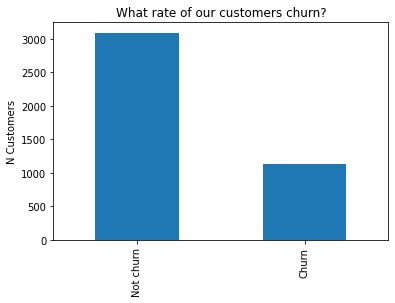

In [12]:
train.churn.value_counts().plot.bar().set_title("Churn")
plt.title("What rate of our customers churn?")
plt.xticks((0,1),["Not churn", "Churn"])
plt.ylabel("N Customers")

In [13]:
#noah add descriptive data points

mean_charges = train[train.churn == 1].monthly_charges.mean()
total_losses = train[train.churn == 1].monthly_charges.count()

print(f'''
On average, we are losing {train[train.churn == 1].shape[0] / train.shape[0]:.0%} of our customers. This might not seem like a lot, but in terms of dollars, this 
means that every time a customer churns, we lose about ${mean_charges:.0f} a month. In otherwords, we could be potentially
loosing, on average, about ${(mean_charges * total_losses):,.0f}.

''')


On average, we are losing 27% of our customers. This might not seem like a lot, but in terms of dollars, this 
means that every time a customer churns, we lose about $74 a month. In otherwords, we could be potentially
loosing, on average, about $83,605.




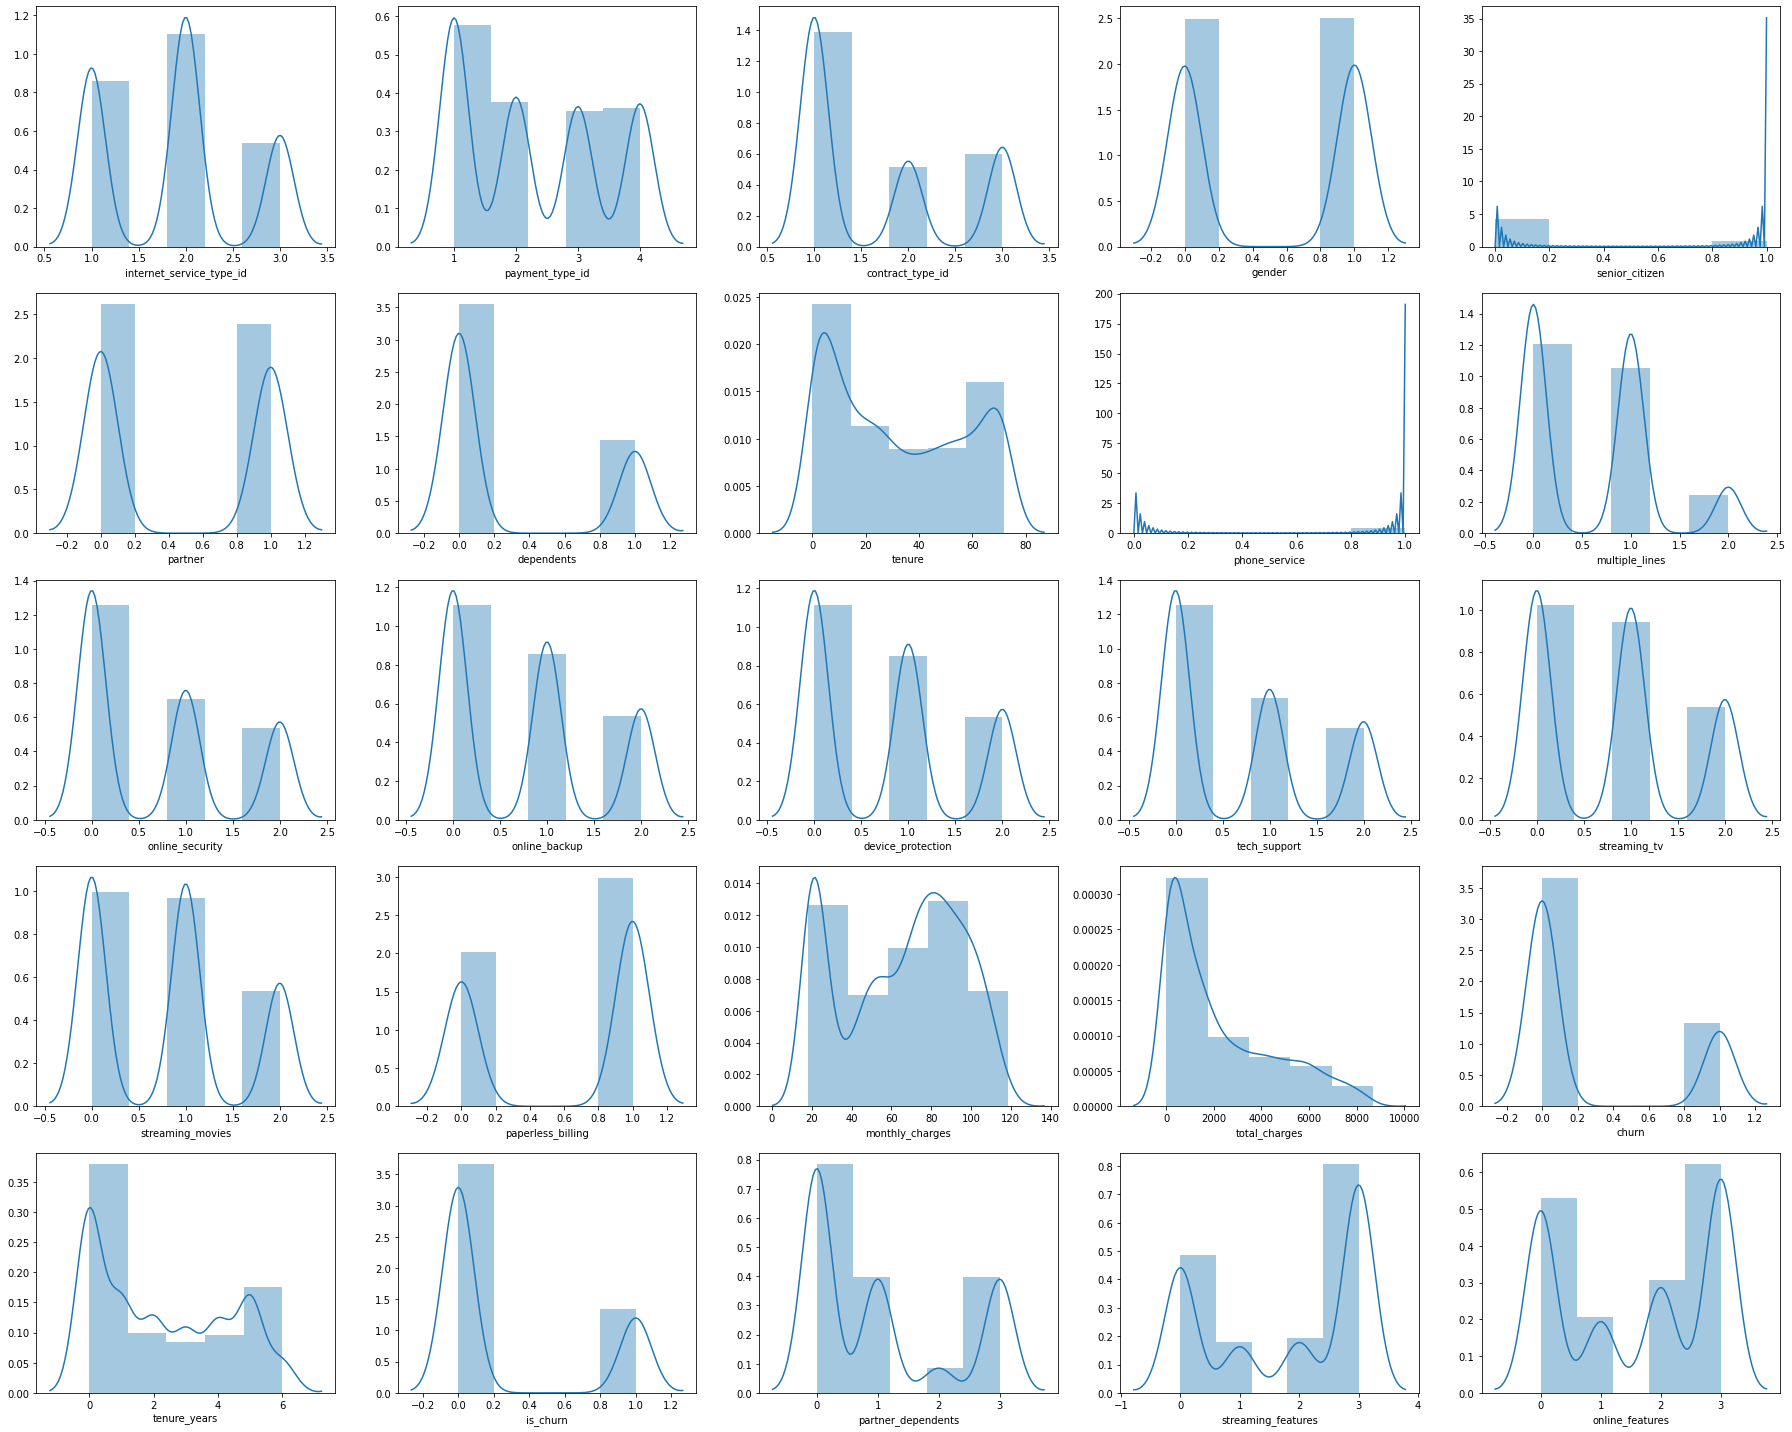

In [14]:
#distribution plots of numerical data in database

f = plt.figure(figsize=(25,20))
continuous_data = train.select_dtypes(include=["int", "float"])

for i in range(0,25):
    f.add_subplot(5,5, i+1)
    sns.distplot(continuous_data.iloc[:,i], bins=5)
plt.tight_layout()
plt.show()

Looking at the distribution of the data, we can see that most of the data is not normally distributed. We will do some exploration, and decide what columns to drop, before scaling using a linear scaler to evenly distribute the data. My two key take-aways at the this moment are:

1. Once we get to modeling, it is likely better to use `monthly_charges` than `total_charges`. Not only does `monthly_charges` has no imputed values, but also it is more normally distributed than `total_charges`, which is very right skewed. Ultimately, this could be fixed with scaling, but given that both variables are highly dependent on each other, we will need to drop one for modeling purposes anyways. 
1. `Tenure` is also not normally distributed. I suspect this will be another key feature in predicting churn, so it will likely need to be scaled. Again, `tenure` seems more normally distributed than `tenure_years`, so it is likely we chose `tenure` for modeling, given that both variables are codependent, and thus we shouldn't use both if we want to have high accuracy in our models.

## Is there a corelation between the variables?

Text(0.5, 1.0, 'Heatmap of correlation between variables')

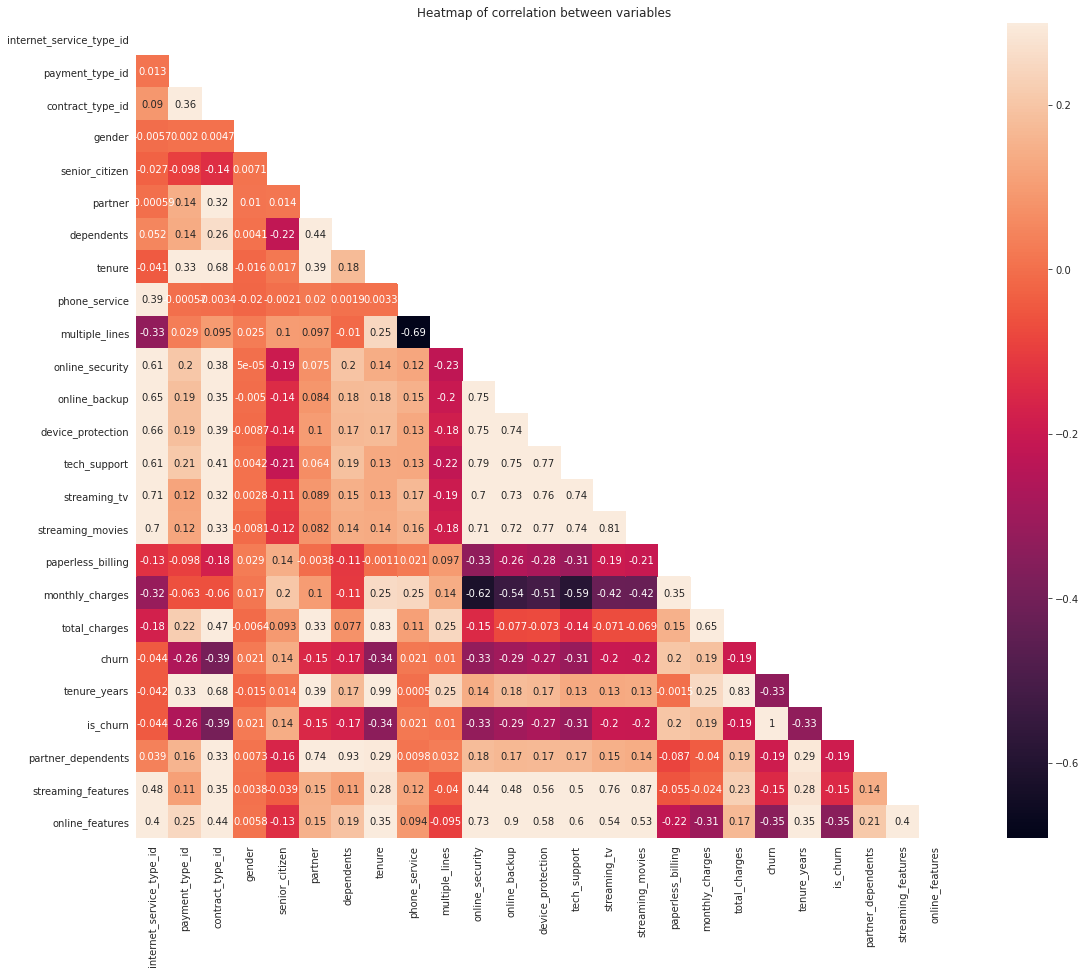

In [65]:
mask = np.zeros_like(train.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
     f, ax = plt.subplots(figsize=(20, 15))
     ax = sns.heatmap(train.corr(), mask=mask, vmax=.3, square=True, annot=True)
plt.title("Heatmap of correlation between variables")

As mentioned above, we want to have features that are completely independent of each other - as these will provide the most accurate patterns that the models can use to make predictions (with the exeption of KNN). The only features that seem to have a high correlation are `monthly_charges` with the premium features, which includes `online_security`, `online_backup`, `device_protection`, `tech_support` and `streaming`. This makes sense, as you would expect that the more features you have, the bigger the change in monthly price. It is a bit odd, however, that they are negatively correlated, as you would expect that as more features are added, the price per month would increase. Given that premium features can be a key indicator on whether a person might churn, we will do a pearson's r correlation test to see if the variables are independent of each other or not.

* $H_0$: There is no significant correlation between `monthly_charges` and the premium features. 
* $H_a$: There is a significant correlation between `monthly_charges` and the premium features. 

* $\alpha$ = 0.05

In [16]:
#mention online features?
group = train[["online_security", "online_backup", "tech_support", "device_protection", "monthly_charges"]]

for col in range(0,4):
    r, p = stats.pearsonr(train.monthly_charges, train[group.columns[col]])
    if p > 0.05:
        print(f"The p value for {group.columns[col]} is higher than our alpha, and thus we fail to reject the null hypothesis")
    else:
        print(f'The p value of {group.columns[col]} is {p:.010f}')
print('''
      
Beacuse all of our p's are smaller than our alpha, so we reject the null hypothesis. This means that there
is a linear correlation between monthly_charges and all these premium categories, and thus shouldn't be used together for 
modeling

''')

The p value of online_security is 0.0000000000
The p value of online_backup is 0.0000000000
The p value of tech_support is 0.0000000000
The p value of device_protection is 0.0000000000

      
Beacuse all of our p's are smaller than our alpha, so we reject the null hypothesis. This means that there
is a linear correlation between monthly_charges and all these premium categories, and thus shouldn't be used together for 
modeling




Another two variables that we want to check whether are highly correlated (and we would expect them to be) is monthly_charges and total_charges

* $H_0$: There is no significant correlation between `monthly_charges` and `total_charges`. 
* $H_a$: There is a significant correlation between `monthly_charges` and `total_chages`. 

* $\alpha$ = 0.05

In [17]:
r, p = stats.pearsonr(train.monthly_charges, train.total_charges)

p

0.0

As expected - our p value is 0, which is smaller than our alpha, and thus we know that we shouldn't use both `total_charges` and `monthly_charges` together for modeling.

In [18]:
# is the total_charges accurate? Is it the same if we calculate it using monthly_charges and tenure?

original = train.total_charges.mean()
calculated = train.monthly_charges * train.tenure

print(f'{calculated.mean():.2f}')
print(f'{original:.2f}')

2253.68
2254.94


## Are there clear groupings where a customer is more likely to churn?

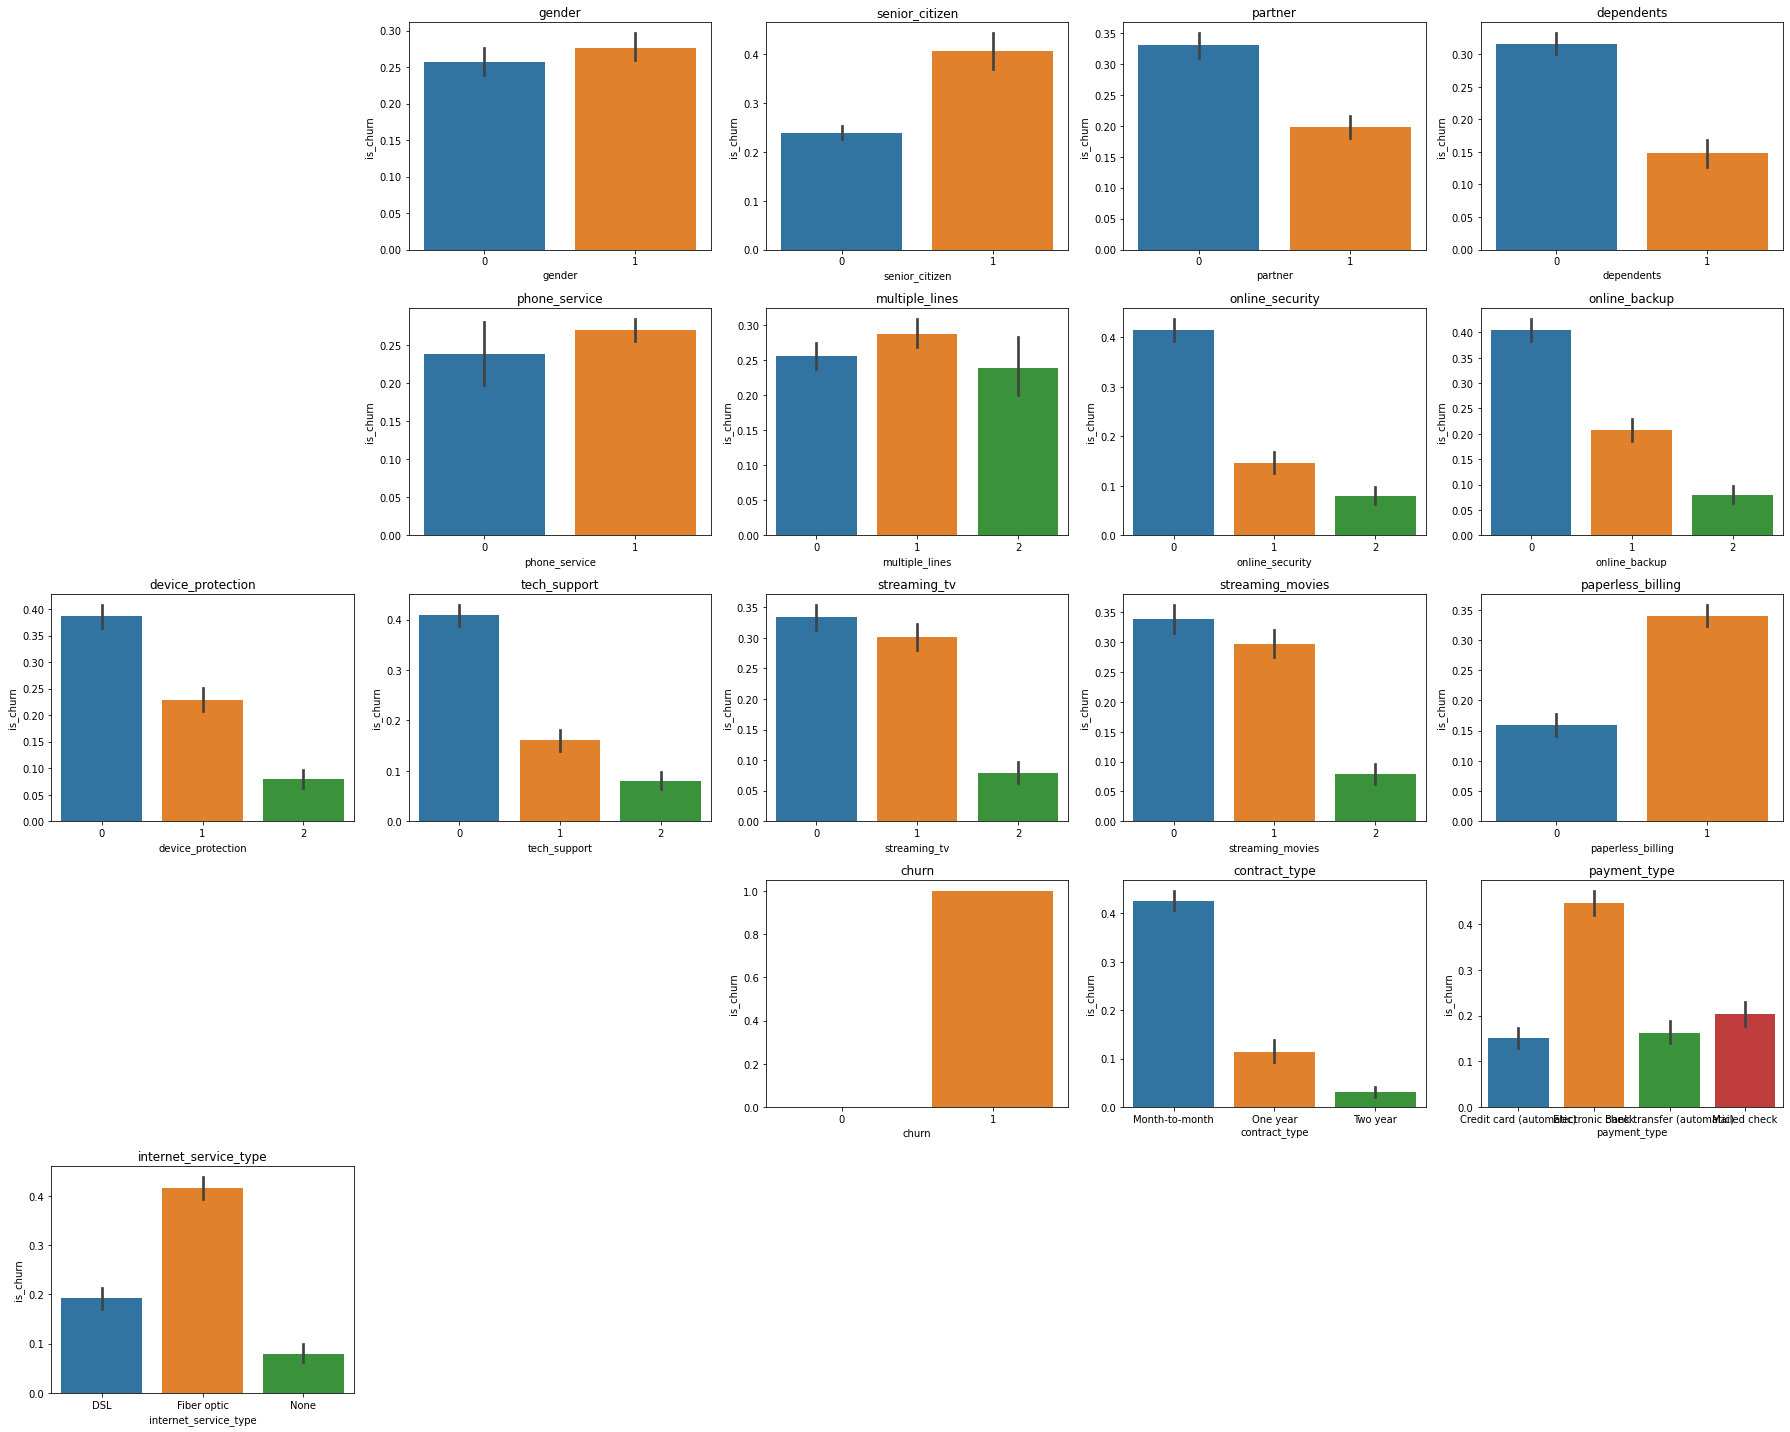

In [19]:
f = plt.figure(figsize=(25,20))
for i in range(0,21):
    if len(train.groupby(train.iloc[:,i+3])) < 5:
        f.add_subplot(5,5, i+1)
        sns.barplot(data=train, y="is_churn", x=train.iloc[:,i+3])
        plt.title(train.columns[i+3])
plt.tight_layout()

plt.show()

Are there clear groupings where a customer is more likely to churn?

There are actually quite a lot of groupings that can serve as an indicator of churn. It might be too many, however, and some new features might need to be engineered. 

From what we can see - the features that at this point don't seem to have any major differences are:

* `gender`
* `phone_service`
* `multiple_lines`
* `streaming_service`

The features that seems to be some of the best indicators are:

* `payment_type`
* `contract_type`
* `internet_service_type`
* `dependents`
* `partner`

Other features that are worth investigating are:

* `online_security`
* `tech_support`
* `senior_citizen` 
* `device_protection`

These features (with the exclusion of `senior_citizen`) seem to be additional commodities that are offered, and clients that usually take up on these features seem to be less likely to churn. While this might not be as useful for modeling, this can is something that can be used as a potential metric to improve customer rentention. 

It is important first to understand what percentage of the customer population actually has these features.

In [20]:
train[train["online_security"]== 1].customer_id.value_counts().sum() / train.shape[0]

0.2835502958579882

So about 28% of the customer population has opted in for online_security, which is actually higher than I initially suspected, and means it could be a good metric for modeling afterall.

In [21]:
train[train["tech_support"]== 1].customer_id.value_counts().sum() / train.shape[0]

0.2849704142011834

In [22]:
# Does this population overlap a lot? 

tech_support = train["tech_support"]== 1
security = train["online_security"]== 1

train[tech_support & security].customer_id.value_counts().sum() / train.shape[0]

0.15171597633136094

It doesn't seem that individuals have multiple "premium" features, as only 15% of the customer population has both options.

In [23]:
## At this point, we speculate that payment_type and contract_type have some of the bigger impact in customer churning. I will do a t-test to compare if there is a significant different.

# Below is a one-tail t test for all contract types:
for i in range(0,3):
    x = train[train.contract_type == train.contract_type.unique()[0 + i]].is_churn
    mu = train.is_churn.mean()

    t_stat, p = stats.ttest_1samp(x, mu)
    
    print(f"Contract Type = {train.contract_type.unique()[0 + i]}")
    print(f't = {t_stat:.3}')
    print(f'p = {p:.10f}')
    print()

Contract Type = Month-to-month
t = 15.5
p = 0.0000000000

Contract Type = One year
t = -14.1
p = 0.0000000000

Contract Type = Two year
t = -42.9
p = 0.0000000000



There are two methods of dealing with features with `No internet service`.
    1.  Treat as another No result, because they do not have the feature:
    This is problematic because it is actually an `n/a` result not truly `no`
    2.  Treat as a seperate value:
    `No internet service` is directly correlated with `phone service` and `internet service type`: `None`

In the end we chose to treat as a seperate value.

In [24]:
telco.tech_support.value_counts()

No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64

In [46]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?

group = ["online_security", "online_backup", "tech_support", "device_protection"]

print("Legend")
print("1: positive case")
print("0: negative case")
print('2: customer cannot be offered the service (n/a)')
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="mean")

Legend
1: positive case
0: negative case
2: customer cannot be offered the service (n/a)


churn                                                                 0  \
online_security online_backup tech_support device_protection              
0               0             0            0                  64.264348   
                                           1                  77.810473   
                              1            0                  70.027670   
                                           1                  74.791748   
                1             0            0                  72.071067   
                                           1                  84.838028   
                              1            0                  77.339109   
                                           1                  89.859091   
1               0             0            0                  65.048485   
                                           1                  71.322436   
                              1            0                  64.100000   
                                           1                  80.074609   
                1             0            0                  72.972072   
                                           1                  84.613136   
                              1            0                  74.647170   
                                           1                  90.617096   
2               2             2            2                  21.199460   

churn                                                                 1  
online_security online_backup tech_support device_protection             
0               0             0            0                  70.307551  
                                           1                  82.483740  
                              1            0                  73.658511  
                                           1                  90.939744  
                1             0            0                  77.894175  
                                           1                  94.065663  
                              1            0                  79.621667  
                                           1                  92.889474  
1               0             0            0                  71.742857  
                                           1                  85.995238  
                              1            0                  78.632353  
                                           1                  84.503125  
                1             0            0                  78.700000  
                                           1                  90.797222  
                              1            0                  89.092857  
                                           1                  97.790909  
2               2             2            2                  20.320833

Overall - there is not a huge difference for all the different groups in temrs of cost. The most drammatic is perhaps in customers that have `tech_support` and `device_protection`. Customers who didn't churn had a monthly charge of `$75`, but customers that churn, and had the same features, had monthly charges of \$94, which is a huge difference for the same products. I suspect this might be influenced by contract types - since we know customers on  fixed plans are less likely to churn. This might mean that some of these features come as free for customers in `One-year` or `Two-year` contracts, but unfortunately we can't know for sure based on the data alone.

In [47]:
# Does the monthly charges of people with online_security, tech_support, device_protection and online_backup different than the rest?
group = ["online_security", "online_backup", "tech_support", "device_protection"]
print("Legend")
print("1: positive case")
print("0: negative case")
print('2: customer cannot be offered the service (n/a)')
pd.pivot_table(train, values="monthly_charges", index=group, columns="churn", aggfunc="count")

Legend
1: positive case
0: negative case
2: customer cannot be offered the service (n/a)


churn                                                           0    1
online_security online_backup tech_support device_protection          
0               0             0            0                  345  437
                                           1                  148  123
                              1            0                  103   47
                                           1                  103   39
                1             0            0                  178  103
                                           1                  142   83
                              1            0                  101   30
                                           1                  121   19
1               0             0            0                  132   56
                                           1                   78   21
                              1            0                   77   17
                                           1                  128   16
                1             0            0                  111   23
                                           1                  118   18
                              1            0                  106   14
                                           1                  272   11
2               2             2            2                  833   72

When we look at the actual count (rather than the mean), we see that in many cases, the difference in mean monthly_charges might be very different because of the overall size of each population. The majority of customers that churn didn't have these features. This is something we will explore later. 

Another key take-away is the fact that a very large number of customers actually don't have `internet_service`, which can mean this is a key indicator for predicting churn. We will explore this further in the modeling phase. 

In [48]:
# Is there a difference in the number of ppl that have premium plans between the different contract types?
print("Legend")
print("1: positive case")
print("0: negative case")
print('2: customer cannot be offered the service (n/a)')
pd.pivot_table(train, index=group, columns="contract_type", values="monthly_charges")

Legend
1: positive case
0: negative case
2: customer cannot be offered the service (n/a)


contract_type                                                 Month-to-month  \
online_security online_backup tech_support device_protection                   
0               0             0            0                       67.571477   
                                           1                       80.008685   
                              1            0                       70.139189   
                                           1                       80.439706   
                1             0            0                       73.596121   
                                           1                       89.883462   
                              1            0                       73.073387   
                                           1                       89.029688   
1               0             0            0                       66.386667   
                                           1                       75.703846   
                              1            0                       70.472917   
                                           1                       82.881250   
                1             0            0                       71.622436   
                                           1                       82.640278   
                              1            0                       76.335938   
                                           1                       89.071429   
2               2             2            2                       20.431447   

contract_type                                                  One year  \
online_security online_backup tech_support device_protection              
0               0             0            0                  67.227273   
                                           1                  79.135556   
                              1            0                  75.300000   
                                           1                  74.302439   
                1             0            0                  76.683333   
                                           1                  88.215217   
                              1            0                  80.698684   
                                           1                  90.327778   
1               0             0            0                  71.979310   
                                           1                  71.578750   
                              1            0                  65.232258   
                                           1                  81.610465   
                1             0            0                  78.867073   
                                           1                  89.112766   
                              1            0                  75.140244   
                                           1                  90.428409   
2               2             2            2                  20.866514   

contract_type                                                  Two year  
online_security online_backup tech_support device_protection             
0               0             0            0                  84.087500  
                                           1                  81.423077  
                              1            0                  70.995455  
                                           1                  82.845455  
                1             0            0                  78.680000  
                                           1                  80.105769  
                              1            0                  83.961290  
                                           1                  90.859524  
1               0             0            0                  62.066667  
                                           1                  77.672500  
                              1            0                  57.836667  
                                           1                  79.262338  
                1

When we look at the mean `monthly_charge`, grouped by `contract_type`, the biggest take-away is perhaps the fact that when none of the products are present, the cost of `Two-year` contracts is significantly higher. This is likely due to the fact that these customers had had a longer tenure, and monthly_charges increase over time. As a result, this is likely not correlated to the premium features. 

Other than that - most of the data points are actually fairly close to each other. This means that perhaps premium products are not included in some of the longer term contracts.

In [49]:
print("Legend")
print("1: positive case")
print("0: negative case")
print('2: customer cannot be offered the service (n/a)')
pd.pivot_table(train, index=group, columns="contract_type", values="monthly_charges", aggfunc="count")

Legend
1: positive case
0: negative case
2: customer cannot be offered the service (n/a)


contract_type                                                 Month-to-month  \
online_security online_backup tech_support device_protection                   
0               0             0            0                             745   
                                           1                             213   
                              1            0                             111   
                                           1                              68   
                1             0            0                             232   
                                           1                             130   
                              1            0                              62   
                                           1                              32   
1               0             0            0                             150   
                                           1                              39   
                              1            0                              48   
                                           1                              24   
                1             0            0                              78   
                                           1                              36   
                              1            0                              32   
                                           1                              21   
2               2             2            2                             318   

contract_type                                                 One year  \
online_security online_backup tech_support device_protection             
0               0             0            0                        33   
                                           1                        45   
                              1            0                        28   
                                           1                        41   
                1             0            0                        39   
                                           1                        69   
                              1            0                        38   
                                           1                        45   
1               0             0            0                        29   
                                           1                        40   
                              1            0                        31   
                                           1                        43   
                1             0            0                        41   
                                           1                        47   
                              1            0                        41   
                                           1                        44   
2               2             2            2                       218   

contract_type                                                 Two year  
online_security online_backup tech_support device_protection            
0               0             0            0                         4  
                                           1                        13  
                              1            0                        11  
                                           1                        33  
                1             0            0                        10  
                                           1                        26  
                              1            0                        31  
                                           1                        63  
1               0             0            0                         9  
                                           1                        20  
                              1            0                        15  
                                           1                        77  
                1             0            0      

When we look at the count - we see that, especially in the `Two-year` group, there are some very low data points, compared to the other groups. This is likely affecting the means that we saw early, which explains the big difference in cost when no premium products were being purchased. 

### Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

* $H_0$: There no difference in price for customers that have churn (when controlling for services) versus those that haven't churn.

* $H_a$: There is a difference in price for customers that have churn (when controlling for services) versus those that haven't churn.

$\alpha$ = 0.05

In [29]:
phone_id = train.phone_service == 1
internet = train.internet_service_type_id == 1
security = train.online_features == 0
support = train.tech_support == 0
device = train.device_protection == 0
contract = train.contract_type_id == 1
churn = train.is_churn == 1


x1 = train[phone_id & internet & security & support & device & contract & churn].monthly_charges
x2 = train[phone_id & internet & security & support & device & contract & ~churn].monthly_charges

t, p = stats.ttest_ind(x1,x2)

print(f"t = {t}")
print(f"p = {p:.6f}")

t = 0.1527237445184859
p = 0.878802


We see that in this case, we fail to reject the null hypothesis, as the mean monthly charges for customers that have churned versus customers that haven't churned are not significantly different. This means that customers aren't necesarly churning for price sensitive reasons. 

Text(27.79250651041668, 0.5, 'monthly charges')

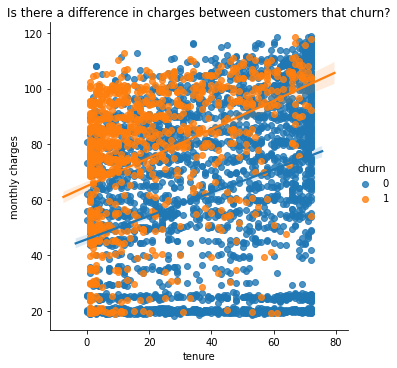

In [59]:
sns.lmplot(data=train, x='tenure', y='monthly_charges', hue = 'churn')
plt.title("Is there a difference in charges between customers that churn?")
plt.ylabel('monthly charges')

However, when we look at the distribution of the datapoints, we actually see that overall, there is a big difference in price between customers that churn and customers that didn't churn. 

## Is there a significant difference in monthly charges between customers that use automatic banking?

* $H_0$: There no difference in churn rate for customers that use automatic payments.

* $H_a$: There is a difference in churn rate for customers that use automatic payments.

$\alpha$ = 0.05

In [31]:
train.payment_type.value_counts()

Electronic check             1462
Mailed check                  955
Credit card (automatic)       913
Bank transfer (automatic)     895
Name: payment_type, dtype: int64

In [32]:
card = train.payment_type == "Credit card (automatic)"
bank = train.payment_type == "Bank transfer (automatic)" 
automatic_banking = card | bank
churn = train.is_churn == 1

x1 = train[automatic_banking].is_churn
x2 = train[~automatic_banking].is_churn

t, p = stats.ttest_ind(x1,x2)

print(f"t = {t}")
print(f"p = {p:.6f}")

t = -14.400519026868128
p = 0.000000


In [33]:
x1 = train[automatic_banking].is_churn.mean()
x2 = train[~automatic_banking].is_churn.mean()

if x1 < x2:
    print("On average, there is a significant difference in churn rate between customers that use the automatic payment methods, versus those who didn't")
else: 
    print("There is no significant difference in churn rate")

On average, there is a significant difference in churn rate between customers that use the automatic payment methods, versus those who didn't


Because our p-value is smaller than our alpha - we can reject the null hypothesis. This means that we should keep `payment_types` for modeling purposes.

## Is there a tenure that month-to-month customers are most likely to churn

In [34]:
train.groupby(["is_churn", "contract_type"]).tenure.mean()

is_churn  contract_type 
0         Month-to-month    20.236960
          One year          40.900259
          Two year          56.945010
1         Month-to-month    13.606820
          One year          47.200000
          Two year          60.406250
Name: tenure, dtype: float64

In [35]:
for i in range(0, 3):
    print(f'''
    The average number of months we retain a customer on a {train.contract_type.unique()[0 + i]} contract is: {train[train["contract_type"] == train.contract_type.unique()[0 + i]].tenure.mean():.2f}
    '''
    )


    The average number of months we retain a customer on a Month-to-month contract is: 17.41
    

    The average number of months we retain a customer on a One year contract is: 41.62
    

    The average number of months we retain a customer on a Two year contract is: 57.05
    


In [36]:
# How many customers are in each contract type?

train.groupby("contract_type").contract_type.count()

contract_type
Month-to-month    2339
One year           872
Two year          1014
Name: contract_type, dtype: int64

The majority of customers are on a one-month contract. Which means that we are working really hard to acquire new customers - but we are not doing enough to retain them. This often seen as a huge financial burdern.

In [37]:
# What is the total revenue, by contract?

train.groupby("contract_type").total_charges.sum().round(0)

contract_type
Month-to-month    3071618.0
One year          2627766.0
Two year          3827719.0
Name: total_charges, dtype: float64

Not surprisingly, the majority of the revenue comes from customers in two-year contracts. These are the high value targets. The revenue from monthly customers is also substancial, and this acrtually is likely to have the most room for improvement, given that the churn is so high.

## What is a tenure, by `contract type`, that customers churn?

In [38]:
train[train["contract_type"] == "Month-to-month"].groupby("tenure").is_churn.agg(["mean", "sum"]).nlargest(15, columns="sum")

,mean,sum
tenure,,
1,0.612299,229
2,0.496599,73
3,0.466667,56
4,0.481132,51
5,0.481481,39
7,0.476923,31
9,0.461538,30
10,0.491803,30
8,0.426230,26


The key take-away from the table above is that the **majority of our customers that are on the `Month-to-month` contract type churn within the first five months.** It is difficult to tell from the data what this might be, but we suspect this might be due to higher than expected costs, or a bad expericnce with customer service.

Text(0.5, 1.0, "Most 'Month-to-month' customers churn in the first 5 months")

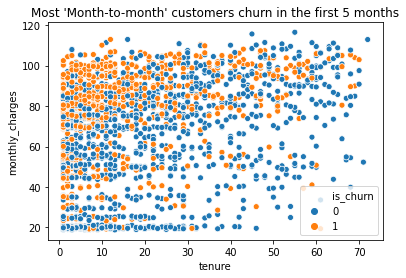

In [39]:
sns.scatterplot(data=train[train.contract_type == "Month-to-month"], x="tenure", y="monthly_charges", hue="is_churn")
plt.title("Most 'Month-to-month' customers churn in the first 5 months")

Interesting finding - about 852 ppl are churning after the first 5 months for customers that have a monthly contract. It doesn't seem that price alone is the main driver, as there are plently of users that are paying in near the upper bound and aren't churning.

Do customers that churn after the first month have premium offerings?

In [40]:
tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    feature = train[group.columns[i]] == 1
    print(group.columns[i])
    print(f"{train[tenure & churn & feature & contract][group.columns[i]].sum()}, out of {train[tenure & churn & contract].shape[0]}")
    print()


Customers that churned on a Month-to-month contract during the first 5 months
online_security
35, out of 448

online_backup
52, out of 448

tech_support
43, out of 448

device_protection
61, out of 448



In [41]:
tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

# We use a loop to run through the different premium products, and print the results
print("Customers that didn't churn on a Month-to-month contract after 5 months")
for i in range(0,4):
    feature = train[group.columns[i]] == 1
    print(group.columns[i])
    print(f"{train[tenure & ~churn & feature & contract][group.columns[i]].sum()}, out of {train[tenure & churn & contract].shape[0]}")
    print()

Customers that didn't churn on a Month-to-month contract after 5 months
online_security
50, out of 448

online_backup
53, out of 448

tech_support
45, out of 448

device_protection
34, out of 448



At first glance, there is not a huge difference. This likely means that premium products are not enough to retain customers.

In [42]:
# What about for payment methods?


tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    payment = train.payment_type == train.payment_type.unique()[0 + i]
    print(train.payment_type.unique()[0 + i])
    print(f"{train[tenure & churn & contract & payment].shape[0]}, out of {train[tenure & churn & contract].shape[0]}")
    print()


Customers that churned on a Month-to-month contract during the first 5 months
Credit card (automatic)
27, out of 448

Electronic check
264, out of 448

Bank transfer (automatic)
31, out of 448

Mailed check
126, out of 448



In [43]:
# What about for payment methods?

tenure = train.tenure <= 5
churn = train.is_churn == 1
contract = train.contract_type == "Month-to-month"

group = train[["online_security", "online_backup", "tech_support", "device_protection"]]

print("Customers that churned on a Month-to-month contract during the first 5 months")
for i in range(0,4):
    payment = train.payment_type == train.payment_type.unique()[0 + i]
    print(train.payment_type.unique()[0 + i])
    print(f"{train[tenure & ~churn & contract & payment].shape[0]}, out of {train[tenure & ~churn & contract].shape[0]}")
    print()

Customers that churned on a Month-to-month contract during the first 5 months
Credit card (automatic)
38, out of 380

Electronic check
140, out of 380

Bank transfer (automatic)
27, out of 380

Mailed check
175, out of 380



Again, not a huge difference between the two groups - which hints at the fact that these features might also not be at the heart of why customers churn.

In [44]:
# What is the payment method distribution?

train.payment_type.value_counts()

Electronic check             1462
Mailed check                  955
Credit card (automatic)       913
Bank transfer (automatic)     895
Name: payment_type, dtype: int64

In [45]:
pd.pivot_table(train, index=["senior_citizen", "dependents", "gender", "partner"], values="monthly_charges", columns="payment_type")

payment_type                              Bank transfer (automatic)  \
senior_citizen dependents gender partner                              
0              0          0      0                        63.639041   
                                 1                        71.759524   
                          1      0                        65.775000   
                                 1                        69.592268   
               1          0      0                        48.100000   
                                 1                        65.665487   
                          1      0                        57.042857   
                                 1                        64.776582   
1              0          0      0                        66.602000   
                                 1                        81.424468   
                          1      0                        82.308621   
                                 1                        85.755172   
               1          0      0                              NaN   
                                 1                        58.350000   
                          1      0                              NaN   
                                 1                        73.462500   

payment_type                              Credit card (automatic)  \
senior_citizen dependents gender partner                            
0              0          0      0                      60.071831   
                                 1                      70.337931   
                          1      0                      63.452961   
                                 1                      74.393548   
               1          0      0                      52.437931   
                                 1                      64.953516   
                          1      0                      59.205769   
                                 1                      63.785081   
1              0          0      0                      66.580769   
                                 1                      74.610294   
                          1      0                      83.263333   
                                 1                      87.456452   
               1          0      0                      94.800000   
                                 1                      84.775000   
                          1      0                            NaN   
                                 1                      91.487500   

payment_type                              Electronic check  Mailed check  
senior_citizen dependents gender partner                                  
0              0          0      0               71.618089     40.825781  
                                 1               83.131780     56.278302  
                          1      0               71.175493     43.561239  
                                 1               78.091453     51.956897  
               1          0      0               69.104839     37.512222  
                                 1               73.179048     40.806579  
                          1      0               70.277500     43.298438  
                                 1               71.386893     36.831933  
1              0          0      0               79.323295     64.835000  
                                 1               86.715132     60.271429  
                          1      0               76.620492     53.304545  
                                 1               84.633594     54.221429  
               1          0      0                     NaN     80.450000  
                                 1               87.400000     67.000000  
                          1      0              101.300000           NaN  
                                 1               82.850000     61.150000

My new theory is that payment method is likely a good reason why customers churn, along with other potential reasons. This means to indicate that customers not on automatic payments are more likely to churn. There is not one particular demographic that is more likely to use the electronic check, which leads me to believe this can be a good indicator of churn probability.

However, the key benefit of payment_type is the convenience that comes from automatically paying, versus the constant remeinder of cost when you manually pay. This information can't really be pulled from the data so it might be difficult to quantify. 

## Is there a tenure that `one_year` customers are most likely to churn

In [46]:
train[train["contract_type"] == "One year"].groupby("tenure").is_churn.agg(["mean", "sum"]).nlargest(15, columns="sum")

,mean,sum
tenure,,
58,0.315789,6
67,0.285714,6
53,0.200000,5
48,0.285714,4
54,0.266667,4
66,0.181818,4
39,0.272727,3
45,0.250000,3
46,0.272727,3


In [47]:
# Do only two customers really churn after 12 months? This is when their contracts would be ending, so you would expect higher churn.

tenure = train.tenure == 12
contract = train.contract_type == "One year"

train[tenure & contract].is_churn.sum()

2

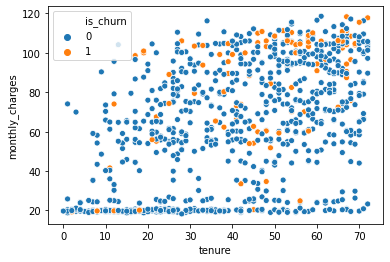

In [48]:
sns.scatterplot(data=train[train.contract_type == "One year"], x="tenure", y="monthly_charges", hue="is_churn")

Weirdly - is doesn't seem that there are a lot of customers that are churning after 12 months, which is what you would expect. 

Not as many people churning on one-year contracts (~230). They are the smallest group. There is no particular tenure month that seems to have the highest churn rate.

## ## Is there a tenure that two year customers are most likely to churn

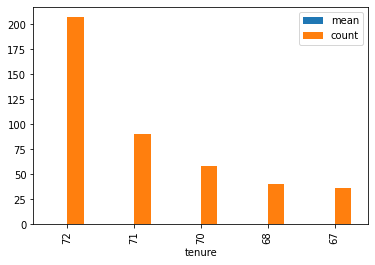

In [49]:
train[train["contract_type"] == "Two year"].groupby("tenure").is_churn.agg(["mean", "count"]).nlargest(5, columns="count").plot.bar()

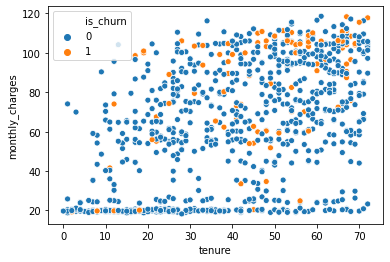

In [50]:
sns.scatterplot(data=train[train.contract_type == "One year"], x="tenure", y="monthly_charges", hue="is_churn")

It seems that most customers on two -year contracts begin to churn after 70 months or more. Other than that, it seems fairly low. 

Text(0.5, 1.0, 'When do customers churn?')

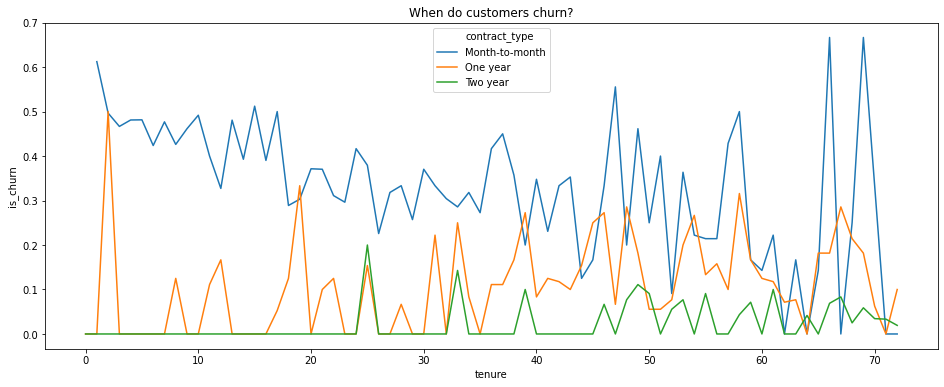

In [51]:
plt.figure(figsize=(16,6))
sns.lineplot('tenure', 'is_churn', hue='contract_type', data=train, ci=None)
plt.title("When do customers churn?")

## Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point?

In [52]:
def subset_churn_data(column_list):
    df = pd.DataFrame(train.groupby((train.monthly_charges // 5)*5).is_churn.mean())
    for c in column_list:
        subset_list = train[c].value_counts().index
        for i in subset_list:
            df[i] = train[train[c] == i].groupby((train.monthly_charges // 5)*5).is_churn.mean()
    return df

In [53]:
column_list = ['internet_service_type', 'payment_type', 'contract_type', 'dependents']
churn = subset_churn_data(column_list)
churn.head(1)

,is_churn,Fiber optic,DSL,None,Electronic check,Mailed check,Credit card (automatic),Bank transfer (automatic),Month-to-month,Two year,One year,0,1
monthly_charges,,,,,,,,,,,,,
15.0,0.09589,NaN,NaN,0.09589,0.228571,0.107143,0.026316,0.068966,0.195946,0.01626,0.042553,0.102222,0.085714


In [54]:
def make_churn_bar_plots(df):
    f = plt.figure(figsize=(16,100))
    x = churn.shape[1]
    for i in range(0, x):
        f.add_subplot(20, 1, i+1)
        sns.barplot(data=churn, y=churn.iloc[:,i], x=churn.index)
        plt.title(churn.columns[i])
        plt.ylabel("Churn rate")
    plt.tight_layout()
    plt.show() 
    

The following series of bar charts examines the affect of monthly price on churn rate.   What we continue to see is that as monthly charges increase, churn rate decreases for service types (Fiber optic and DSL).  The spike in churn rate after $60 is from the introduction of Fiber Optic customers to the customer pool.  The churn rate increases after about $75 a month for contracted (one and two years) customers.

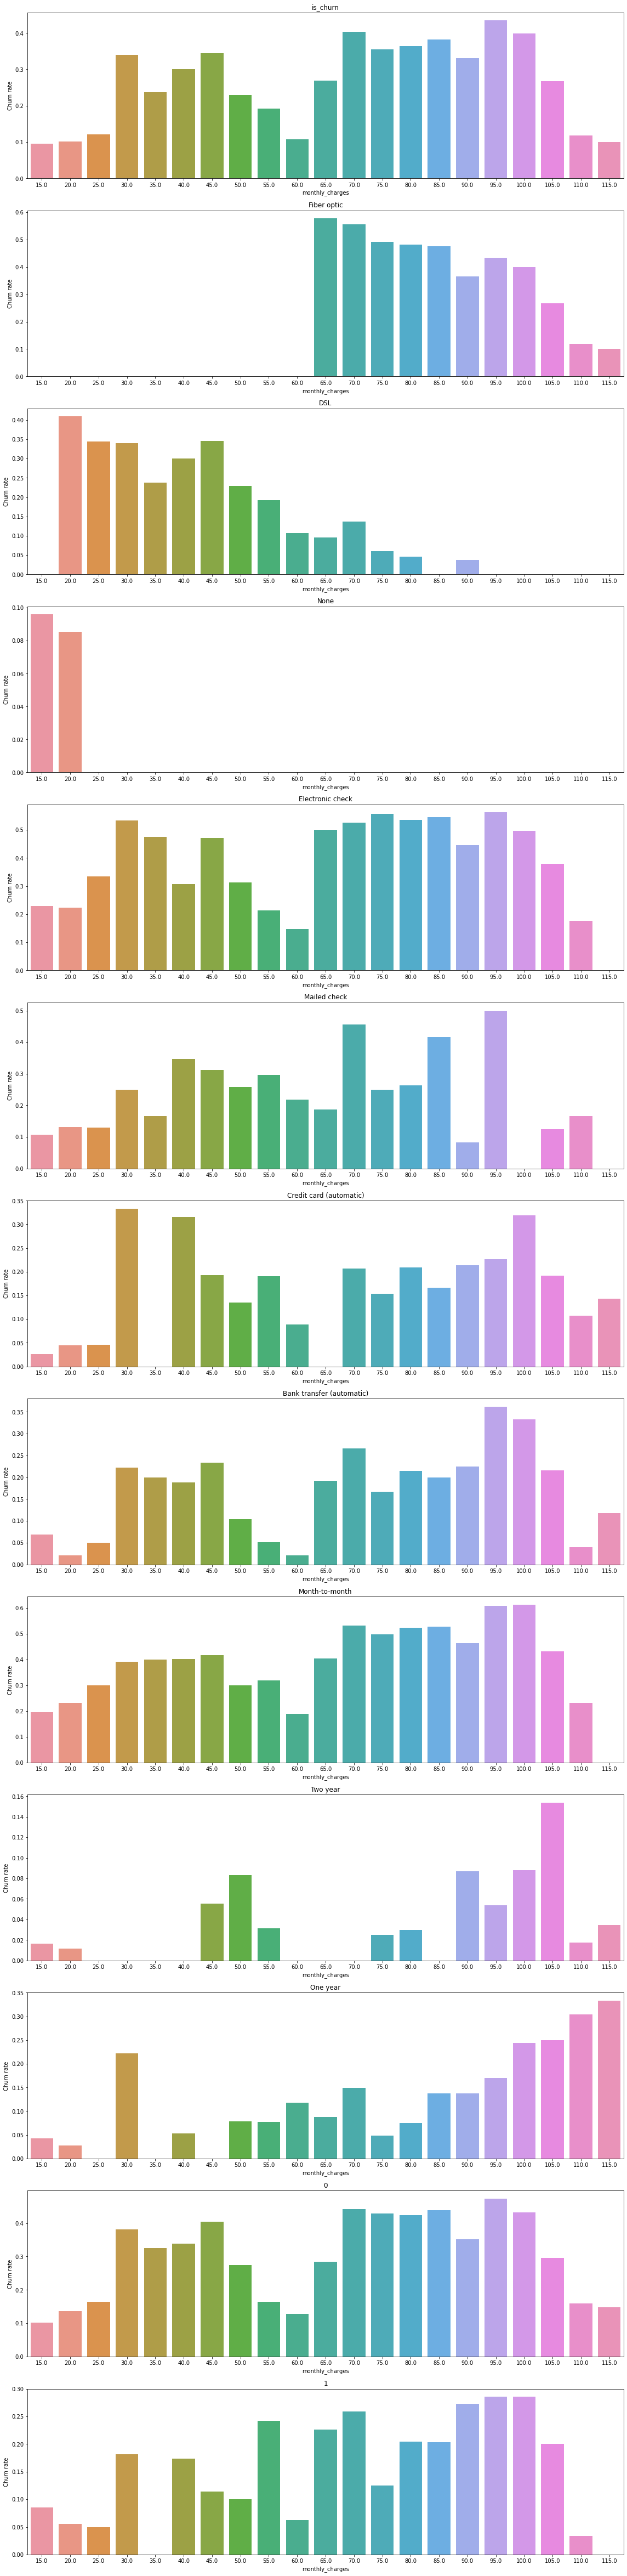

In [55]:
make_churn_bar_plots(churn)

## If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

$churn\_rate = \frac{(n\_users_0 - n\_users_n)}{n_users_0}$
$for \  _n \ months$

In [56]:
contract = train.contract_type == "Month-to-month"
no_churn = train.is_churn == 0
tenure = train.tenure <= 12


churn_rate_m = (train[contract & tenure].shape[0] - train[contract & no_churn & tenure].shape[0]) / train[contract & tenure].shape[0]

In [57]:
contract = train.contract_type == "One year"
no_churn = train.churn == 0
tenure = train.tenure <= 12

churn_rate_1 = (train[contract & tenure].shape[0] - train[contract & no_churn & tenure].shape[0]) / train[contract & tenure].shape[0]

In [58]:
print(f'''

After the 12th month, the churn rate for customers on a month-to-month plan is {churn_rate_m:.1%}, while for customers on a 1-year plan is {churn_rate_1:.1%}

The clearly tells us that the churn rate is not comparable between both services. The key-takeway here is that we need to convert more month-to-month customers into yearly customers, as they are less likely to churn
''')



After the 12th month, the churn rate for customers on a month-to-month plan is 50.4%, while for customers on a 1-year plan is 8.0%

The clearly tells us that the churn rate is not comparable between both services. The key-takeway here is that we need to convert more month-to-month customers into yearly customers, as they are less likely to churn



## Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers).

Text(0.5, 0, 'Tenure in years')

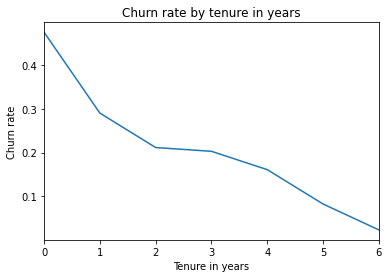

In [57]:
train.groupby(train.tenure // 12).is_churn.mean().plot()
plt.title("Churn rate by tenure in years")
plt.ylabel("Churn rate")
plt.xlabel("Tenure in years")

Overall, as tenure increases, churn rate decreases.  The most valuable customers (those who continue to pay every month) are also the least likely to churn.  Continuing insight:  **find ways to hold onto customer through the very voltile first year and you are more likely to retain that customer**

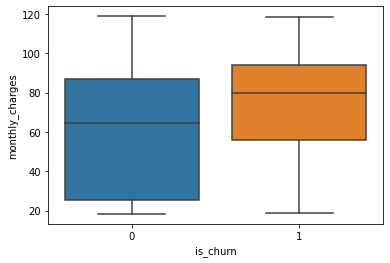

In [60]:
# Are there any outliers that could be throwing off the data?

sns.boxplot(data=train, x="is_churn", y="monthly_charges")

There don't seem to be any outliers. I does seem that customers that churn had on average a higher monthly charges. We know that when control for some of the services, the monthly_charges is not significantly different, but that the graph above shows that there could be some other features that are spiking the price for some customers, and this new price might be driving customers to churn.

# Scaling

Now that the exploration is done - we need to start scaling the data so that we can model it.  Scaling will be necessary to accurately model using logistic regression and k-nearest-neighbor algorithms.

In [61]:
# We use a function that takes our data, scales the monthly_charges and tenure features, and replaces the scaled 
# information in our new dfs.
X_train, X_validate, X_test = prepare.prep_for_modeling(train, validate, test)

In [62]:
y_train = train.is_churn
y_validate = validate.is_churn
y_test = test.is_churn

In [63]:
# We make sure that the data is still what we think it is, by ensuring that 
# our data shape is still accurate

assert(X_train.shape[0] == train.shape[0])
assert(X_validate.shape[0] == validate.shape[0])
assert(X_test.shape[0] == test.shape[0])

assert(y_train.shape[0] == train.shape[0])
assert(y_validate.shape[0] == validate.shape[0])
assert(y_test.shape[0] == test.shape[0])

# Modeling

Before begining to model - We will write down all the possible outcomes. 

In this case, becasue we are trying to predict the customers that will churn, our **our positive values == churn, or 1**.

The possible outcomes:

TP: Predict that a customer will churn, and it churns
TN: Predict that a customer will not churn, and it doesn't churn
FP: Predict that a customer will churn, and it doesn't churn
FN: Predict that a customer will not churn, and it churn.

In this case, because we are trying to identify customers that are churning, we want to minimize the number of FN in our predictions, because it is more expensive to predict that a customer will not churn, and it churns, than it is to predict that a customer will churn, and in reality it wasn't going to churn. 

The cost difference comes from the potential value of a customer, plus the cost of then acquiring a customer to replace it (which according to a Harvard study, it can cost as much as 10 times more to acquire a new customer than it is to retain one). 

This is why we will focus on having a model with a high **recall** score, because this will help select a model that minimizes FN. At the same time, however, we can't afford to assume that all customer will churn, so our **precision** score also has to be relatively high.

In [64]:
# We create a new dataframe to store the predicted values from all the models. 
# This makes it significantly easier to compare our model's performances against the actual values, 
# and the baseline.

evaluation = pd.DataFrame({"actual": y_train})
evaluation["baseline"] = 0

In [65]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(evaluation.actual, evaluation.baseline), index = labels, columns = labels)
matrix

,0,1
0,3096,0
1,1129,0


We chose the baseline to be *no churn or "0"* because that is the most common value found in our target variable. As such, we will be comparing our model's effectiveness against whether they perform better than if we just assume that none of our customers will churn. Because our baseline only predicts 0, if we were to look at money saved (assuming that we could retain all customers identified as likely to churn), our baseline would cost us $83,605 a month, which is how much money we are currently loosing every month with customers that are churning.

### Features being dropped:

The following features are being droped prior to modeling. The reasons are:

1. New encoded columns were created to represent the data:

    * `online_features`
    * `streaming_tv`
    * `streaming_movies`
    * `partner`
    * `dependents`
    * `online_security`
    * `online_backup`
    * `contract_type`
    * `payment_type`
    * `internet_service_type`

1. Exploration phased showed there was no significant difference in churn with these group:

    * `gender`

1. Not relevant:

    * `customer_id`

### Logistic Regression

In [66]:
telco = acquire.read_telco_data()

In [67]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [68]:
logict, y_pred = model.run_lg(X_train, y_train)
evaluation["logistic_regression_1"] = y_pred

In [69]:
accuracy_score, matrix, report = model.accuracy_report(logict, y_pred, y_train)

In [70]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.80
      0    1
0  2791  305
1   531  598


,0,1,accuracy,macro avg,weighted avg
precision,0.840157,0.662237,0.80213,0.751197,0.792613
recall,0.901486,0.529672,0.80213,0.715579,0.802130
f1-score,0.869741,0.588583,0.80213,0.729162,0.794610
support,3096.000000,1129.000000,0.80213,4225.000000,4225.000000


In [71]:
coef = logict.coef_[0]
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = logict.coef_[0]
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

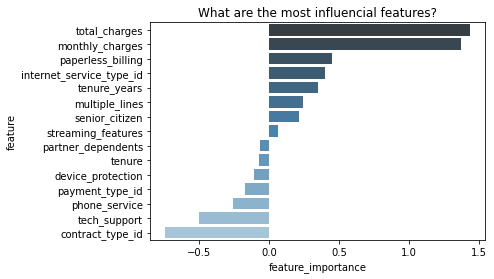

In [72]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

The logistic regression model performs well - and has a good accuracy, but really low recall and precision rates. If we can't get better scores from the other model, I suggest we return to this one, and try to improve the score by optimizing for threshold to maximize accuracy.  (We will address that total_charges is highly dependent on tenure and monthly_charges).

### Decision Tree Classifier

In [73]:
telco = acquire.read_telco_data()

In [74]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [75]:
# The following loop lets as see the accuracy values based on the max_depth, and the difference in score
# between our validate data. Because decision trees are prone to overfitting, we want to make sure now that 
# we are not choosing a model that is too overfit.
for i in range(1,26):
    clf, y_pred = model.run_clf(X_train, y_train, i)
    print(f'max_depth = {i}, train_accuracy = {clf.score(X_train, y_train):.2%}, diff_accuracy = {(clf.score(X_train, y_train) - clf.score(X_validate, y_validate))/clf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 74.89%, diff_accuracy = -1%
max_depth = 3, train_accuracy = 78.30%, diff_accuracy = -2%
max_depth = 4, train_accuracy = 79.05%, diff_accuracy = -2%
max_depth = 5, train_accuracy = 79.69%, diff_accuracy = -1%
max_depth = 6, train_accuracy = 80.33%, diff_accuracy = 1%
max_depth = 7, train_accuracy = 81.49%, diff_accuracy = 2%
max_depth = 8, train_accuracy = 82.49%, diff_accuracy = 4%
max_depth = 9, train_accuracy = 84.05%, diff_accuracy = 8%
max_depth = 10, train_accuracy = 85.33%, diff_accuracy = 9%
max_depth = 11, train_accuracy = 86.56%, diff_accuracy = 12%
max_depth = 12, train_accuracy = 88.19%, diff_accuracy = 15%
max_depth = 13, train_accuracy = 89.94%, diff_accuracy = 20%
max_depth = 14, train_accuracy = 91.72%, diff_accuracy = 22%
max_depth = 15, train_accuracy = 93.04%, diff_accuracy = 26%
max_depth = 16, train_accuracy = 94.22%, diff_accuracy = 27%
max_depth = 17, train_accuracy = 95.36

The danger with Decision tree is that it can very easily become over fit. With the loop above, we can see all the different accuracy scores for many different values for `max_depth`. Based on the information, we want to keep a train accuracy as high as possible, while still ensuring that the model is not overfit. If we choose a `max_depth` of 10, we can get an accuracy of 85%, and keep the difference between train and validate samples relatively small.

In [76]:
clf, y_pred = model.run_clf(X_train, y_train, 6)
evaluation["decision_tree_model"] = y_pred

In [77]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)

In [78]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.80
      0    1
0  2684  412
1   419  710


,0,1,accuracy,macro avg,weighted avg
precision,0.864969,0.632799,0.803314,0.748884,0.802929
recall,0.866925,0.628875,0.803314,0.747900,0.803314
f1-score,0.865946,0.630831,0.803314,0.748388,0.803119
support,3096.000000,1129.000000,0.803314,4225.000000,4225.000000


In [79]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(evaluation.actual, evaluation.decision_tree_model), index = labels, columns = labels)
matrix

Accuracy of Decision Tree classifier on training set: 0.80


,0,1
0,2684,412
1,419,710


In [80]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed 
this model,and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 710 customers that would eventually churn. This means that if we deployed 
this model,and were able to retain all these customers, we would make an
additional $52,577 by not loosing those customers





In [81]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = clf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

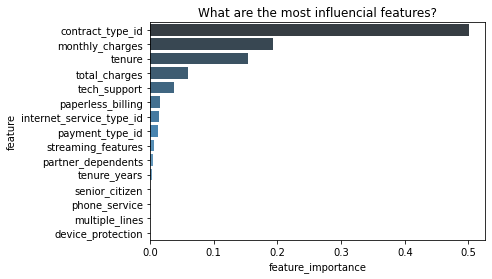

In [82]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Overall, we see that the model is doing fairly well at predicting values when the positive is `not_churning`. While this is good, this is not what we are looking for, as we want to predict the probability that a customer will churn. The precision and recall values are still good when we look at churning as the positive, but they need to be substancially imporved, as failing to accurately predict if a customer will churn can cost the company significant money.

### Random Forest

In [83]:
telco = acquire.read_telco_data()

In [84]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [85]:
for i in range(1,26):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 77.33%, diff_accuracy = -2%
max_depth = 3, train_accuracy = 78.89%, diff_accuracy = -3%
max_depth = 4, train_accuracy = 79.10%, diff_accuracy = -3%
max_depth = 5, train_accuracy = 79.86%, diff_accuracy = -1%
max_depth = 6, train_accuracy = 80.47%, diff_accuracy = -1%
max_depth = 7, train_accuracy = 81.85%, diff_accuracy = 1%
max_depth = 8, train_accuracy = 83.46%, diff_accuracy = 3%
max_depth = 9, train_accuracy = 85.63%, diff_accuracy = 6%
max_depth = 10, train_accuracy = 87.88%, diff_accuracy = 11%
max_depth = 11, train_accuracy = 90.86%, diff_accuracy = 13%
max_depth = 12, train_accuracy = 92.97%, diff_accuracy = 18%
max_depth = 13, train_accuracy = 94.79%, diff_accuracy = 19%
max_depth = 14, train_accuracy = 96.24%, diff_accuracy = 23%
max_depth = 15, train_accuracy = 96.69%, diff_accuracy = 22%
max_depth = 16, train_accuracy = 97.68%, diff_accuracy = 24%
max_depth = 17, train_accuracy = 97.

In [86]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 8)
evaluation["random_forest_model"] = y_pred

In [87]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)

In [88]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.83
      0    1
0  2844  252
1   447  682


,0,1,accuracy,macro avg,weighted avg
precision,0.864175,0.730193,0.834556,0.797184,0.828372
recall,0.918605,0.604074,0.834556,0.761340,0.834556
f1-score,0.890559,0.661173,0.834556,0.775866,0.829263
support,3096.000000,1129.000000,0.834556,4225.000000,4225.000000


In [89]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed
this model, and were able to retain all these customers, we would make an additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those 
customers

''')


The model accurately predicted 682 customers that would eventually churn. This means that if we deployed
this model, and were able to retain all these customers, we would make an additional $50,504 by not loosing those 
customers




In [90]:
coef = rf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

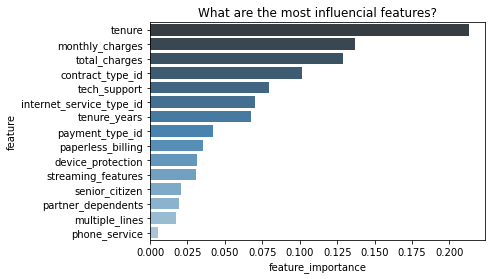

In [91]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

The random forest model proves to be slightly better than the decision tree model. It has better recall and precision when it comes to predicting churn as the positive value, however, it still has much better predictive scores when looking at predicting customers that will not churn. I suspect that some of the current features are actually creating an bias, leading the model to inaccurately predict some values. 

In terms of the most important coefficients, `tenure`, `monthly_charges`, and `total_charges` are tied for most important featues, `contract_type_id` is also still fairly important.

### KNN

In [92]:
telco = acquire.read_telco_data()
X_train, X_validate, X_test = prepare.full_prep_for_modeling(telco)

In [93]:
for k in range(1,25):
    knn, y_pred = model.run_knn(X_train, y_train, k)
    print(f'max_depth = {k}, train_accuracy = {knn.score(X_train, y_train):.2%}, diff_accuracy = {(knn.score(X_train, y_train) - knn.score(X_validate, y_validate))/knn.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 99.72%, diff_accuracy = 39%
max_depth = 2, train_accuracy = 86.13%, diff_accuracy = 12%
max_depth = 3, train_accuracy = 86.25%, diff_accuracy = 12%
max_depth = 4, train_accuracy = 84.12%, diff_accuracy = 8%
max_depth = 5, train_accuracy = 83.10%, diff_accuracy = 7%
max_depth = 6, train_accuracy = 81.85%, diff_accuracy = 4%
max_depth = 7, train_accuracy = 81.28%, diff_accuracy = 3%
max_depth = 8, train_accuracy = 81.44%, diff_accuracy = 2%
max_depth = 9, train_accuracy = 81.02%, diff_accuracy = 2%
max_depth = 10, train_accuracy = 80.99%, diff_accuracy = 1%
max_depth = 11, train_accuracy = 80.57%, diff_accuracy = 0%
max_depth = 12, train_accuracy = 80.69%, diff_accuracy = -1%
max_depth = 13, train_accuracy = 80.64%, diff_accuracy = -1%
max_depth = 14, train_accuracy = 80.80%, diff_accuracy = -0%
max_depth = 15, train_accuracy = 80.66%, diff_accuracy = 0%
max_depth = 16, train_accuracy = 80.62%, diff_accuracy = -0%
max_depth = 17, train_accuracy = 80.26%, d

In [94]:
knn, y_pred = model.run_knn(X_train, y_train, 2)
evaluation["knn_model"] = y_pred

In [95]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)

In [96]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.86
      0    1
0  3095    1
1   585  544


,0,1,accuracy,macro avg,weighted avg
precision,0.841033,0.998165,0.861302,0.919599,0.883021
recall,0.999677,0.481842,0.861302,0.740760,0.861302
f1-score,0.913518,0.649940,0.861302,0.781729,0.843085
support,3096.000000,1129.000000,0.861302,4225.000000,4225.000000


In [97]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 544 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $40,285 by not loosing those customers





In [98]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      3096
           1       1.00      0.48      0.65      1129

    accuracy                           0.86      4225
   macro avg       0.92      0.74      0.78      4225
weighted avg       0.88      0.86      0.84      4225



KNN has an increadible precision score, but misses 50% of the cases when it comes to recall. For this particular case, we want to make sure that our recall is as high as possible, becasue we want to minimize the number of False Negatives. The reason for this is that in this case, we can either predict a customer will not churn, and then they churn - that's an expensive loss. While the opposite, would be we predict that a customer will churn, when they likely weren't. While we still want to maximize reasources and time to target customers that are likely to churn, it is more expensive (in terms of potential dollars) if our model has more false negatives. 

# Conclusion

In [99]:
for i in range(0,6):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} = {report.accuracy[0]:.2f}')

actual = 1.00
baseline = 0.73
logistic_regression_1 = 0.80
decision_tree_model = 0.80
random_forest_model = 0.83
knn_model = 0.86


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
for i in range(0,6):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} recall = {report["1"][1]:.2f}')

actual recall = 1.00
baseline recall = 0.00
logistic_regression_1 recall = 0.53
decision_tree_model recall = 0.63
random_forest_model recall = 0.60
knn_model recall = 0.48


At this point, the random forest model seems to be the best model. The reason for that is because it has the highest recall. It also has the highest overall average for precision and recall, which is something we need for this case. I believe that some of the features might need to be encoded with `OneHotEncoder`, because they are throwing the models off. I suspect this is the case becasue the continuous features are consistently getting higher influence than what we predicted during the exploration face. Additionally, becasue we used `LabelEncoders` on features that aren't necesarily booleans, then the models might be giving more weight to some features just becasue they have a higher number. At this point, I suggest going back to the data prep and encoding these features.

# Modeling II

After the first round of modeling - we have now learned that the models are performing well - but I want to try to improve them by doing some feature engineering.

1. Create OneHotEncoder 
2. Run through the models again
3. Evaluate

### Features being dropped: 

In addition to some of the previously dropped features, we are dropping the following features: 

1. New encoded columns were created:
    * `internet_service_type_id`
    * `internet_service_type`
    * `contract_type` 
    * `payment_type`
    * `streaming_tv`
    * `streaming_movies`
    * `partner` 
    * `dependents` 
    * `online_security`
    * `online_backup`
    * `contract_type_id` 
    * `payment_type_id`
    
1. Features were found to be highly correlated to `monthly_charges` or `tenure`
    * `tech_support` 
    * `device_protection`
    * `phone_service`
    * `tenure_years`
    * `total_charges`

In [101]:
# For each model - we want to make sure that the data is "clean" - as such, we use this function to pull and prep the data
# This new function split, scales, encodes and returns the data
telco = acquire.read_telco_data()
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [102]:
X_train.shape[1] == X_validate.shape[1]

True

In [103]:
X_train.head()

,senior_citizen,tenure,multiple_lines,paperless_billing,monthly_charges,partner_dependents,streaming_features,online_features,payment_typeBank transfer (automatic),payment_typeCredit card (automatic),payment_typeElectronic check,payment_typeMailed check,contract_typeMonth-to-month,contract_typeOne year,contract_typeTwo year,internet_service_typeDSL,internet_service_typeFiber optic,internet_service_typeNone
440,0,0.097222,0,0,0.517920,3,3,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
67,0,0.013889,0,1,0.365977,0,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
600,0,0.041667,0,0,0.353357,0,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4883,0,0.916667,1,1,0.848561,3,3,2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1258,0,0.861111,0,1,0.528521,3,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Modeling

### Logistic Regression

In [104]:
telco = acquire.read_telco_data()

In [105]:
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [106]:
logict, y_pred = model.run_lg(X_train, y_train)
evaluation["logistic_regression_2"] = y_pred

In [107]:
accuracy_score, matrix, report = model.accuracy_report(logict, y_pred, y_train)

In [108]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.80
      0    1
0  2770  326
1   525  604


,0,1,accuracy,macro avg,weighted avg
precision,0.840668,0.649462,0.79858,0.745065,0.789574
recall,0.894703,0.534987,0.79858,0.714845,0.798580
f1-score,0.866844,0.586693,0.79858,0.726768,0.791982
support,3096.000000,1129.000000,0.79858,4225.000000,4225.000000


In [109]:
coef = logict.coef_[0]
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = logict.coef_[0]
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

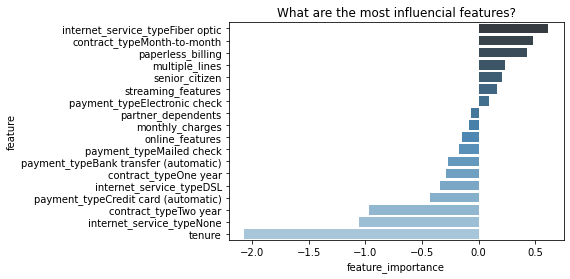

In [110]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

The model performs about the same as the MVP. Given that the other models perfomed better, I will move on to Decision Tree and Random Forest, but if we see that the models are performing worse with the new encoded features, I will return to adjust the threshold and see if we can improve our scores that way.

### Decision Tree

In [111]:
# We do a for loop to calculate the 
for i in range(1,26):
    clf, y_pred = model.run_clf(X_train, y_train, i)
    print(f'max_depth = {i}, train_accuracy = {clf.score(X_train, y_train):.2%}, diff_accuracy = {(clf.score(X_train, y_train) - clf.score(X_validate, y_validate))/clf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 75.81%, diff_accuracy = -1%
max_depth = 3, train_accuracy = 78.65%, diff_accuracy = -2%
max_depth = 4, train_accuracy = 79.31%, diff_accuracy = -2%
max_depth = 5, train_accuracy = 79.50%, diff_accuracy = -1%
max_depth = 6, train_accuracy = 80.52%, diff_accuracy = 1%
max_depth = 7, train_accuracy = 81.68%, diff_accuracy = 4%
max_depth = 8, train_accuracy = 83.01%, diff_accuracy = 6%
max_depth = 9, train_accuracy = 84.28%, diff_accuracy = 9%
max_depth = 10, train_accuracy = 85.61%, diff_accuracy = 10%
max_depth = 11, train_accuracy = 87.01%, diff_accuracy = 12%
max_depth = 12, train_accuracy = 88.78%, diff_accuracy = 16%
max_depth = 13, train_accuracy = 90.11%, diff_accuracy = 19%
max_depth = 14, train_accuracy = 91.53%, diff_accuracy = 22%
max_depth = 15, train_accuracy = 93.07%, diff_accuracy = 24%
max_depth = 16, train_accuracy = 94.56%, diff_accuracy = 28%
max_depth = 17, train_accuracy = 95.7

In [112]:
clf, y_pred = model.run_clf(X_train, y_train, 6)
evaluation["clf_2"] = y_pred

In [113]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)

In [114]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.81
      0    1
0  2687  409
1   414  715


,0,1,accuracy,macro avg,weighted avg
precision,0.866495,0.636121,0.805207,0.751308,0.804934
recall,0.867894,0.633304,0.805207,0.750599,0.805207
f1-score,0.867194,0.634709,0.805207,0.750952,0.805070
support,3096.000000,1129.000000,0.805207,4225.000000,4225.000000


In [115]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 715 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $52,948 by not loosing those customers





Given that this is one of our best looking model - I will compare the evaluation against the X_validate dataset, to ensure that the data is not overfit.

In [58]:
y_pred = clf.predict(X_validate)
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_validate)
print(accuracy_score)
print(matrix)
report

NameError: name 'clf' is not defined

As we can see - the model is working well, and it is not overfit, given that there is not a significant difference in performance when the model is shown new data.

In [117]:
coef = clf.feature_importances_
# We want to check that the coef array has the same number of items as there are features in our X_train dataframe.
assert(len(coef) == X_train.shape[1])
coef = clf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

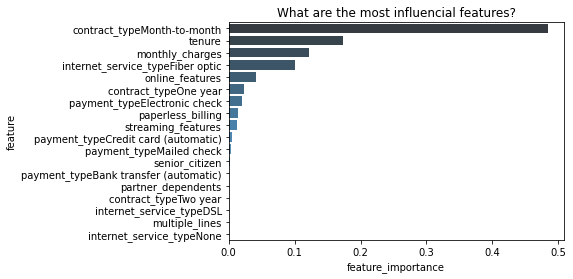

In [118]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

We can see that the model is doing better with the new features. Overall, our recall score improved by 6%, which is a good imporvement. I think the encoding definitively helped, because know we know that out of the contract types, "Month-to-month" is the biggest indicator of churn, which we did observed duing the exploration phase.`Tenure` is the second most important feature, which makes sense, as we saw in the exploration phase that there were clear tenures by contract the customers were more likely to churn. `monthly_charges` is the third most important indicator.

### Random Forest

In [119]:
telco = acquire.read_telco_data()
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [120]:
# We want to find what hyperameter will gives us the best result, 
# so we look at the scores for different parameters, 
# we compare it to the validate score to ensure we are not overfitting
for i in range(1,20):
    rf, y_pred = model.run_rf(X_train, y_train, 1, i)
    print(f'max_depth = {i}, train_accuracy = {rf.score(X_train, y_train):.2%}, diff_accuracy = {(rf.score(X_train, y_train) - rf.score(X_validate, y_validate))/rf.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 73.28%, diff_accuracy = -2%
max_depth = 2, train_accuracy = 77.07%, diff_accuracy = -1%
max_depth = 3, train_accuracy = 78.67%, diff_accuracy = -1%
max_depth = 4, train_accuracy = 79.01%, diff_accuracy = -2%
max_depth = 5, train_accuracy = 80.17%, diff_accuracy = -1%
max_depth = 6, train_accuracy = 80.80%, diff_accuracy = -0%
max_depth = 7, train_accuracy = 81.66%, diff_accuracy = 2%
max_depth = 8, train_accuracy = 83.17%, diff_accuracy = 3%
max_depth = 9, train_accuracy = 84.90%, diff_accuracy = 6%
max_depth = 10, train_accuracy = 87.83%, diff_accuracy = 10%
max_depth = 11, train_accuracy = 90.13%, diff_accuracy = 11%
max_depth = 12, train_accuracy = 92.59%, diff_accuracy = 18%
max_depth = 13, train_accuracy = 93.96%, diff_accuracy = 20%
max_depth = 14, train_accuracy = 95.88%, diff_accuracy = 20%
max_depth = 15, train_accuracy = 96.45%, diff_accuracy = 24%
max_depth = 16, train_accuracy = 97.33%, diff_accuracy = 25%
max_depth = 17, train_accuracy = 97.

In [121]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 8)

threshold = 0.35

predicted_proba = rf.predict_proba(X_train)
predicted = (predicted_proba[:,1] >= threshold).astype('int')
evaluation["rf_2"] = predicted

In [122]:
accuracy_score, matrix, report = model.accuracy_report(rf, predicted, y_train)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.82
      0    1
0  2539  557
1   193  936


,0,1,accuracy,macro avg,weighted avg
precision,0.929356,0.626926,0.822485,0.778141,0.848541
recall,0.820090,0.829052,0.822485,0.824571,0.822485
f1-score,0.871311,0.713959,0.822485,0.792635,0.829263
support,3096.000000,1129.000000,0.822485,4225.000000,4225.000000


In [123]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')



The model accurately predicted 936 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $69,313 by not loosing those customers





In [124]:
coef = rf.feature_importances_
columns = X_train.columns
df = pd.DataFrame({"feature": columns,
                   "feature_importance": coef,
                  })

Text(0.5, 1.0, 'What are the most influencial features?')

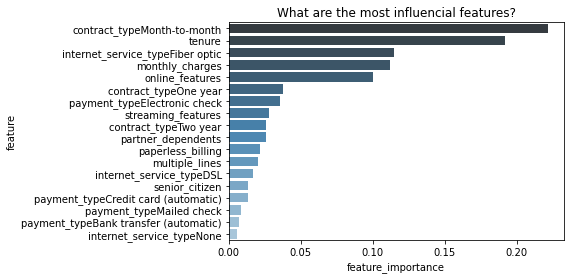

In [125]:
df = df.sort_values(by="feature_importance", ascending=False)
sns.barplot(data=df, x="feature_importance", y="feature", palette="Blues_d")
plt.title("What are the most influencial features?")

Similar to the decision tree model - `month-to-month` and `tenure` are the two most influencial features. This model, however, uses `Fiber_optive` as the third key indicator. We saw during the exploration phase that there were differences in cost between groups that seeminly had the same products. This leads me to believe that `Internet_type` could be an underlying cause for those differences.

Our recall score seems to be lower than we hope - so we will adjust the threshold to label customers with a 35% or higher chance as `churn`. The reason for this is that we want to optimize for recall - and in this case, we have seen that False Negatives are up to 10 times more expensive than False Positives, which is why we are taking the decision to update the threshold.

In [126]:
threshold = 0.35

predicted_proba = rf.predict_proba(X_validate)
predicted = (predicted_proba[:,1] >= threshold).astype('int')

In [127]:
accuracy_score, matrix, report = model.accuracy_report(rf, predicted, y_validate)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.78
     0    1
0  836  217
1   95  261


,0,1,accuracy,macro avg,weighted avg
precision,0.897959,0.546025,0.778566,0.721992,0.809039
recall,0.793922,0.733146,0.778566,0.763534,0.778566
f1-score,0.842742,0.625899,0.778566,0.734321,0.787954
support,1053.000000,356.000000,0.778566,1409.000000,1409.000000


As we can see, this greatly improves our recall.

## KNN

In [128]:
telco = acquire.read_telco_data()
X_train, X_validate, X_test = prepare.full_prep_for_modeling_encoded(telco)

In [129]:
for k in range(1,25):
    knn, y_pred = model.run_knn(X_train, y_train, k)
    print(f'max_depth = {k}, train_accuracy = {knn.score(X_train, y_train):.2%}, diff_accuracy = {(knn.score(X_train, y_train) - knn.score(X_validate, y_validate))/knn.score(X_validate, y_validate):.0%}')

max_depth = 1, train_accuracy = 99.67%, diff_accuracy = 37%
max_depth = 2, train_accuracy = 86.46%, diff_accuracy = 12%
max_depth = 3, train_accuracy = 86.08%, diff_accuracy = 13%
max_depth = 4, train_accuracy = 83.62%, diff_accuracy = 8%
max_depth = 5, train_accuracy = 83.05%, diff_accuracy = 6%
max_depth = 6, train_accuracy = 81.92%, diff_accuracy = 3%
max_depth = 7, train_accuracy = 81.28%, diff_accuracy = 4%
max_depth = 8, train_accuracy = 80.85%, diff_accuracy = 2%
max_depth = 9, train_accuracy = 81.28%, diff_accuracy = 3%
max_depth = 10, train_accuracy = 80.69%, diff_accuracy = 2%
max_depth = 11, train_accuracy = 80.66%, diff_accuracy = 2%
max_depth = 12, train_accuracy = 80.57%, diff_accuracy = 3%
max_depth = 13, train_accuracy = 80.59%, diff_accuracy = 3%
max_depth = 14, train_accuracy = 80.54%, diff_accuracy = 3%
max_depth = 15, train_accuracy = 80.28%, diff_accuracy = 2%
max_depth = 16, train_accuracy = 80.36%, diff_accuracy = 2%
max_depth = 17, train_accuracy = 80.43%, diff_

In [130]:
knn, y_pred = model.run_knn(X_train, y_train, 2)
evaluation["knn_model_2"] = y_pred

In [131]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)

In [132]:
print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.86
      0    1
0  3096    0
1   572  557


,0,1,accuracy,macro avg,weighted avg
precision,0.844057,1.000000,0.864615,0.922028,0.885728
recall,1.000000,0.493357,0.864615,0.746678,0.864615
f1-score,0.915435,0.660735,0.864615,0.788085,0.847374
support,3096.000000,1129.000000,0.864615,4225.000000,4225.000000


In [133]:
print(f'''
The model accurately predicted {matrix[1][1]} customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional ${mean_charges * matrix[1][1]:,.0f} by not loosing those customers


''')


The model accurately predicted 557 customers that would eventually churn. This means that if we deployed this model, 
and were able to retain all these customers, we would make an
additional $41,247 by not loosing those customers





With just a superficial look, I can already tell that our KNN model does not perform much better. It might be that because the majority of points are not likely to churn, they are more likely to be clumped together, which is why the model is doing so well at predicting the negative case (not_churn), but it is struggling at accurately predicting the positive value. The model does have a perfect recall score (which inherently worries me) but it only scores about 50% on the precision score, which is too low for us to use effectively.


## Conclusion

In [134]:
# How do the different models compare on accuracy?
for i in range(0,10):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} = {report.accuracy[0]:.2f}')

actual = 1.00
baseline = 0.73
logistic_regression_1 = 0.80
decision_tree_model = 0.80
random_forest_model = 0.83
knn_model = 0.86
logistic_regression_2 = 0.80
clf_2 = 0.81
rf_2 = 0.82
knn_model_2 = 0.86


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [135]:
# How do the models compare on recall?
for i in range(0,10):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} recall = {report["1"][1]:.2f}')

actual recall = 1.00
baseline recall = 0.00
logistic_regression_1 recall = 0.53
decision_tree_model recall = 0.63
random_forest_model recall = 0.60
knn_model recall = 0.48
logistic_regression_2 recall = 0.53
clf_2 recall = 0.63
rf_2 recall = 0.83
knn_model_2 recall = 0.49


In [136]:
# How do the models compare on f1-score?
for i in range(0,10):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    print(f'{evaluation.columns[i]} f1 = {report["1"][2]:.2f}')

actual f1 = 1.00
baseline f1 = 0.00
logistic_regression_1 f1 = 0.59
decision_tree_model f1 = 0.63
random_forest_model f1 = 0.66
knn_model f1 = 0.65
logistic_regression_2 f1 = 0.59
clf_2 f1 = 0.63
rf_2 f1 = 0.71
knn_model_2 f1 = 0.66


# Test

In [137]:
rf, y_pred = model.run_rf(X_train, y_train, 1, 8)
evaluation["rf_2"] = y_pred

In [138]:
threshold = 0.35

predicted_proba = rf.predict_proba(X_test)
predicted = (predicted_proba[:,1] >= threshold).astype('int')

In [139]:
accuracy_score, matrix, report = model.accuracy_report(rf, predicted, y_test)

print(accuracy_score)
print(matrix)
report

Accuracy on training set: 0.78
     0    1
0  826  199
1  108  276


,0,1,accuracy,macro avg,weighted avg
precision,0.884368,0.581053,0.782115,0.732710,0.801705
recall,0.805854,0.718750,0.782115,0.762302,0.782115
f1-score,0.843287,0.642608,0.782115,0.742948,0.788595
support,1025.000000,384.000000,0.782115,1409.000000,1409.000000


# Conclusion 

At this point, my recommendation would be to use Random Forest, with the scaled and econded features (rf_2). Despite not performing significantly better than the rest of the models, and having a slightly smaller recall than our original random_forest_model, it has the highest recall and precision scores, collectively, which were greatly increased by changing the threshold. I also think that the second phase models are better, because they avoid using features that have a strong correlation with `monthly_charges`, which is the most important coefficient in all the models. The encoded columns also lets us get further insight into what specific varibles within `contract_type` and `internet_type` are most influencial when it comes to predicting churn. We will know look to do a final evaluation by looking at the test data for the first time. The objective is to ensure that the Random Forest model is not overfit, and will work well with new data. 

Important to note, all models perform better than the baseline in predicting customers that are likely to churn. This means that any of our model, if deployed, would be more effective than just using the baseline at predicting churn.

In [140]:
# Can we calculate money saved using the recall rate?

# Do a for loop to get the name of all the models and their recall_rate
recall_rate = []
for i in range(1,10):
    report = model.create_report(evaluation.actual, evaluation.iloc[:,i])
    recall = [f'{evaluation.columns[i]}',f'{report["1"][1]:.2f}']
    recall_rate.append(recall)
              
# Since we stored the information in a list, we can put it together to create a dataframe
df = pd.DataFrame(recall_rate, columns=["model", "recall_rate"])
df.recall_rate = df.recall_rate.astype(float)

# Then we can multiply the recall_rate times the number of actual positive cases to get the number of positive cases each model predicted.
df["tp"] = df.recall_rate * y_train.value_counts()[1]

# Lastly, we can calculate value in dollars by multiplying n_customers times 74, which is the average monthly_rate for customers that churn.
df["models_performance_dollars"] = df["tp"] * 74

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


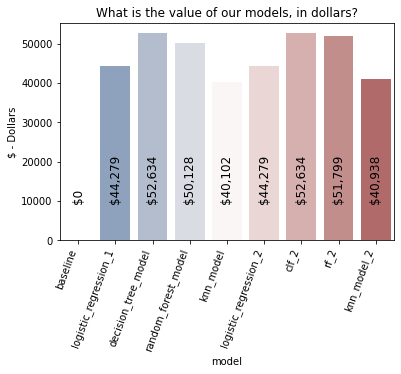

In [141]:
# Plot the df using seaborn
sns.barplot(data=df, x="model", y="models_performance_dollars", palette="vlag")
plt.xticks(rotation=70, ha="right")
plt.title("What is the value of our models, in dollars?")
plt.ylabel("$ - Dollars")
# Use a loop to populate the text values
for i in range(len(df)):
    plt.text(i,10000,f'${df.models_performance_dollars[i]:,.0f}',color = "black", fontsize=12, ha="center", rotation=90)

As we can see - our prefered mode, Random_forest_2 outperforms all the other models when it comes to accurately predicting customers that will churn. With this model, we can be far more effective in targeting these customers with our CRM systems, and if we can retain most of them, can help the company make over `$70,000` in additional revenue by reducing the number of customers that are churning. Just to put it in perspective - `$70,000` is about 25% of our monthly_charges income. As a result, this could signify as significant growth for the company.

# Why do customers churn?

We suspect that the main motivator for customers to churn is price. We see this manifest in different features, like `contract_type` and `internet_service_type`. Given the nature of our business, and the fact that customers can easily compare rates with competitors, and also easily switch between contracts, it makes sense that a customers barrier to exit will be low (becasue there are low to no penalties) and the possibility of finding a cheaper rate is high. 

Another reason why customers are churning, but we can't necesarily prove it from the data, is the fact that customers might have a negative experience either with our product or our customer services. There are many customers (~300) that were paying less than the average monthly_charges, but still churn, meaning that there is a possibility (although we can't prove or disprove it) that their reason for churning was not price related.

Without further data, we can't prove or disprove our main null hypothesis, but at this point we suspect that we can reject our null hypothesis, and accept our alternative hypothesis.

Our original hypothesis are stated below, for reference:

* $H_0$: Customers are not motivated to leave our services, primarily because of financial or price reasons.
* $H_a$: Customers are motivated to leave our services, primarily because of financial or price reasons.

# Suggestions and Key-takeaways:

Every time that a customer leaves, we lose potential revenue. Given that it is up to 10 times more expensive to acquire new customers than it is to retain them, our objective should be to minize churn, in order to increase revenue. Our Random Forest model can help identify potential customers that are likely to churn.

Based on our analysis, we suspect the main driving force in customers churning is price. In our testing we saw that, on average, customers that churn did have a higher monthly charges over customers that didn't churn. 

Our main suggestion is to use our model and target customers that have a high probability of churning by offering them discounts on their subscriptions, either by offering some of the premium products at a cheaper price, or lowering the cost of their base plan. This might seem like it would lower income in the short run, but by lowering our churn rate, we will be able to greatly increase our revenue overall by reducing the amount of money spent trying to acquire more customers.

### Further Investigation:
We have begun to examine modeling that focusses on subset of customer behavior.  Given more time, we think it is worthy to model customer churn by contract type.  `2 year contract` customers and `Phone only` customers churn at a significantly lower rate.  Furthermore, `phone only` customers are less valuable to the company, and efforts should be made to convert them into bundled customers.

# Generate CSV

As the final deliverable - the function below will check the current directory for a file named `telco_customer_churn_predictions.csv`. If the file is not present, it will create a new file with that name.

In [144]:
prepare.check_for_csv_report("telco_customer_churn_predictions.csv")